In [ ]:
# pip install keras-tuner
# import keras_tuner as kt


In [ ]:
import scipy.io
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Input, LSTM, Dense, Concatenate, Reshape
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
import time
import random


In [ ]:
# Carga el archivo .mat
solar_generation = scipy.io.loadmat('/content/drive/MyDrive/Varios/UDENAR/MTE/Códigos Final/Data final/generation_final_1.mat')
energy_demand = scipy.io.loadmat('/content/drive/MyDrive/Varios/UDENAR/MTE/Códigos Final/Data final/demand_final_1.mat')
# selling_price = scipy.io.loadmat('/content/drive/MyDrive/Varios/UDENAR/MTE/Codigos/Data/selling_price.mat')
# buying_price = scipy.io.loadmat('/content/drive/MyDrive/Varios/UDENAR/MTE/Codigos/Data/buying_price.mat')
shift_load = scipy.io.loadmat('/content/drive/MyDrive/Varios/UDENAR/MTE/Códigos Final/Data final/sli_opt_days.mat')
# optimization = scipy.io.loadmat('/content/drive/MyDrive/Varios/UDENAR/MTE/Codigos/Data/optimization_1.mat')

solar_generation = np.array(solar_generation['array'])
energy_demand = np.array(energy_demand['array'])
# selling_price = np.array(selling_price['array'])
# buying_price = np.array(buying_price['array'])
shift_load = np.array(shift_load['array'])
# selling_price = np.array([0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.8, 0.8, 0.8, 1.3, 1.3, 1.3, 1.3, 0.8, 0.8, 0.8, 0.8, 1.3, 1.3, 1.3, 0.8, 0.8])
# selling_price = selling_price.reshape(1, 24)
# buying_price = 0.3 * np.ones((1, 24))
# Pms_Pmb_opt = np.array(optimization['Pms_Pmb_opt'])
# sli_opti_per_prom = np.array(optimization['sli_opti_per_prom'])

# Verificar las dimensiones
print("Dimensiones de datos:")
print("solar_generation:", solar_generation.shape)
print("energy_demand:", energy_demand.shape)
# print("selling_price:", selling_price.shape)
# print("buying_price:", buying_price.shape)
print("shift_load:", shift_load.shape)
# print("Pms_Pmb_opt:", Pms_Pmb_opt.shape)
# print("sli_opti_per_prom:", sli_opti_per_prom.shape)
print("")



Dimensiones de datos:
solar_generation: (5, 5000, 24)
energy_demand: (5, 5000, 24)
shift_load: (5000, 5, 24)



In [ ]:
# Transponer `solar_generation` y `energy_demand`
solar_generation = np.transpose(solar_generation, (1, 0, 2))  # (1000, 5, 24)
energy_demand = np.transpose(energy_demand, (1, 0, 2))        # (1000, 5, 24)
# shift_load = np.transpose(shift_load, (1, 0, 2))        # (1000, 5, 24)

# Verificar las dimensiones
print("Dimensiones de datos:")
print("solar_generation:", solar_generation.shape)
print("energy_demand:", energy_demand.shape)
# print("selling_price:", selling_price.shape)
# print("buying_price:", buying_price.shape)
print("shift_load:", shift_load.shape)
# print("Pms_Pmb_opt:", Pms_Pmb_opt.shape)
# print("sli_opti_per_prom:", sli_opti_per_prom.shape)
print("")

# Expandir `selling_price` y `buying_price`
# selling_price_expanded = np.tile(selling_price[:, None, :], (10000, 5, 1))  # (1000,5 , 24)
# buying_price_expanded = np.tile(buying_price[:, None, :], (10000, 5, 1))    # (1000, 5, 24)

# Expandir `shift_load`
# shift_load_expanded = np.tile(shift_load[:, :, None], (1, 1, 24))  # (1000, 5, 24)

# Concatenar todas las entradas en una sola matriz
X = np.concatenate((solar_generation, energy_demand), axis=1)
# X tendrá la forma (1000, 25, 24) después de la concatenación

X_max = np.max(X)

Y1_max = np.max(shift_load)
# Y2_max = np.max(sli_opti_per_prom)

X = X / X_max

# Normalizar los datos de entrada y salida
# scaler_x = MinMaxScaler()
# scaler_y1 = MinMaxScaler()
# scaler_y2 = MinMaxScaler()

# X = scaler_x.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

# Y_Pms_Pmb_opt = scaler_y1.fit_transform(Pms_Pmb_opt.reshape(-1, Pms_Pmb_opt.shape[-1])).reshape(Pms_Pmb_opt.shape)
# Y_sli_opti_per_prom = scaler_y2.fit_transform(sli_opti_per_prom.reshape(-1, sli_opti_per_prom.shape[-1])).reshape(sli_opti_per_prom.shape)

# Y_Pms_Pmb_opt = Pms_Pmb_opt / Y1_max
Y_sli_opti_per_prom = shift_load / Y1_max

# Dividir los datos en conjuntos de entrenamiento, validación y prueba
X_train, X_test, Y_sli_opti_per_prom_train, Y_sli_opti_per_prom_test = train_test_split(
    X, Y_sli_opti_per_prom, test_size=0.1, random_state=42)

X_train, X_val, Y_sli_opti_per_prom_train, Y_sli_opti_per_prom_val = train_test_split(
    X_train, Y_sli_opti_per_prom_train, test_size=0.20, random_state=42)  # 0.25 x 0.8 = 0.2

# Verificación de dimensiones

print("---Dimensiones de datos de entrada y salida:")
print("Dimensión de X:", X.shape)
# print("Dimensión de Y_Pms_Pmb_opt:", Y_Pms_Pmb_opt.shape)
print("Dimensión de Y_sli_opti_per_prom:", Y_sli_opti_per_prom.shape)
print("")
print("---Datos de entrada:")
print("Dimensión de X_train:", X_train.shape)
print("Dimensión de X_val:", X_val.shape)
print("Dimensión de X_test:", X_test.shape)
print("")
print("---Datos de salida:")
# print("Dimensión de Y_Pms_Pmb_opt_train:", Y_Pms_Pmb_opt_train.shape)
# print("Dimensión de Y_Pms_Pmb_opt_val:", Y_Pms_Pmb_opt_val.shape)
# print("Dimensión de Y_Pms_Pmb_opt_test:", Y_Pms_Pmb_opt_test.shape)
print("")
print("Dimensión de Y_sli_opti_per_prom_train:", Y_sli_opti_per_prom_train.shape)
print("Dimensión de Y_sli_opti_per_prom_val:", Y_sli_opti_per_prom_val.shape)
print("Dimensión de Y_sli_opti_per_prom_test:", Y_sli_opti_per_prom_test.shape)


Dimensiones de datos:
solar_generation: (5000, 5, 24)
energy_demand: (5000, 5, 24)
shift_load: (5000, 5, 24)

---Dimensiones de datos de entrada y salida:
Dimensión de X: (5000, 10, 24)
Dimensión de Y_sli_opti_per_prom: (5000, 5, 24)

---Datos de entrada:
Dimensión de X_train: (3600, 10, 24)
Dimensión de X_val: (900, 10, 24)
Dimensión de X_test: (500, 10, 24)

---Datos de salida:

Dimensión de Y_sli_opti_per_prom_train: (3600, 5, 24)
Dimensión de Y_sli_opti_per_prom_val: (900, 5, 24)
Dimensión de Y_sli_opti_per_prom_test: (500, 5, 24)


In [ ]:
# Definir el modelo
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Capas LSTM
lstm_out = LSTM(128, return_sequences=True)(input_layer)
lstm_out = LSTM(64)(lstm_out)

# Capas densas para cada salida
# dense_out_Pms_Pmb_opt = Dense(112, activation='relu')(lstm_out)
# dense_out_Pms_Pmb_opt = Dense(2 * 24, activation='linear')(dense_out_Pms_Pmb_opt)  # 2 * 24 porque tenemos dos precios por hora
# output_Pms_Pmb_opt = Reshape((2, 24))(dense_out_Pms_Pmb_opt)

dense_out_sli_opti_per_prom = Dense(64, activation='relu')(lstm_out)
dense_out_sli_opti_per_prom = Dense(128, activation='relu')(dense_out_sli_opti_per_prom)
dense_out_sli_opti_per_prom = Dense(5 * 24, activation='linear')(dense_out_sli_opti_per_prom)  # 5 * 24 porque tenemos 5 prosumidores por hora
output_sli_opti_per_prom = Reshape((5, 24))(dense_out_sli_opti_per_prom)

# Definir el modelo con dos salidas
model = Model(inputs=input_layer, outputs=output_sli_opti_per_prom)

# Compilar el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(),
                                                                             tf.keras.metrics.MeanAbsoluteError()])

# Resumen del modelo
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10, 24)]          0         
                                                                 
 lstm_4 (LSTM)               (None, 10, 128)           78336     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 128)               8320      
                                                                 
 dense_8 (Dense)             (None, 120)               15480     
                                                                 
 reshape_2 (Reshape)         (None, 5, 24)             0   

In [ ]:
# def build_model(hp):
#     input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

#     # Capas LSTM
#     lstm_units_1 = hp.Int('lstm_units_1', min_value=32, max_value=256, step=32) #########################################
#     lstm_out = LSTM(units=lstm_units_1, return_sequences=True)(input_layer)

#     lstm_units_2 = hp.Int('lstm_units_2', min_value=16, max_value=128, step=16) #########################################
#     lstm_out = LSTM(units=lstm_units_2)(lstm_out)

#     # Capas densas para cada salida
#     dense_units_1 = hp.Int('dense_units_1', min_value=16, max_value=128, step=16) #########################################
#     dense_out_Pms_Pmb_opt = Dense(units=dense_units_1, activation='relu')(lstm_out)
#     dense_out_Pms_Pmb_opt = Dense(2 * 24, activation='linear')(dense_out_Pms_Pmb_opt)
#     output_Pms_Pmb_opt = Reshape((2, 24))(dense_out_Pms_Pmb_opt)

#     dense_units_2 = hp.Int('dense_units_2', min_value=16, max_value=128, step=16) #########################################
#     dense_out_sli_opti_per_prom = Dense(units=dense_units_2, activation='relu')(lstm_out)
#     dense_out_sli_opti_per_prom = Dense(5 * 24, activation='linear')(dense_out_sli_opti_per_prom)
#     output_sli_opti_per_prom = Reshape((5, 24))(dense_out_sli_opti_per_prom)

#     # Definir el modelo con dos salidas
#     model = Model(inputs=input_layer, outputs=[output_Pms_Pmb_opt, output_sli_opti_per_prom])

#     # Compilar el modelo con una tasa de aprendizaje variable
#     learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]) #########################################
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#                   loss='mse', metrics=['mae'])

#     return model


In [ ]:
# tuner = kt.Hyperband(
#     build_model,
#     objective='val_loss',
#     max_epochs=30,
#     factor=3,
#     directory='/content/drive/MyDrive/Varios/UDENAR/MTE/Codigos/Data/',
#     project_name='hyperparameter_tuning'
# )

# # Definir el callback para detener el entrenamiento temprano
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# # Realizar la búsqueda de hiperparámetros
# tuner.search(X_train, [Y_Pms_Pmb_opt_train, Y_sli_opti_per_prom_train],
#              epochs=50,
#              validation_data=(X_val, [Y_Pms_Pmb_opt_val, Y_sli_opti_per_prom_val]),
#              callbacks=[stop_early])


In [ ]:
# # Obtener los mejores hiperparámetros
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# # Mostrar los hiperparámetros óptimos
# print("Los hiperparámetros óptimos son:")
# for param in best_hps.values:
#     print(f"{param}: {best_hps.values[param]}")

# # Construir el modelo con los mejores hiperparámetros
# model = tuner.hypermodel.build(best_hps)

# # Definir el callback para guardar el mejor modelo
# checkpoint = ModelCheckpoint(
#     filepath='/content/drive/MyDrive/Varios/UDENAR/MTE/Codigos/Data/best_model_optimized.h5',
#     monitor='val_loss',
#     save_best_only=True,
#     mode='min',
#     verbose=1
# )


In [ ]:
# # Entrenar el modelo con los mejores hiperparámetros
# history = model.fit(
#     X_train,
#     [Y_Pms_Pmb_opt_train, Y_sli_opti_per_prom_train],
#     epochs=100,
#     batch_size=16,
#     validation_data=(X_val, [Y_Pms_Pmb_opt_val, Y_sli_opti_per_prom_val]),
#     callbacks=[checkpoint, stop_early]
# )


In [ ]:
# Definir el callback para guardar el mejor modelo
checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Varios/UDENAR/MTE/Codigos/Data/best_model_opt__load_6.h5',         # Ruta donde se guardará el modelo
    monitor='val_loss',               # Métrica que se va a monitorizar
    save_best_only=True,              # Guardar solo el mejor modelo
    mode='min',                       # El mejor modelo será el que tenga la métrica 'val_loss' mínima
    verbose=1                         # Imprimir mensajes cuando se guarda un nuevo modelo
)

# Entrenar el modelo con el callback
history = model.fit(
    X_train,
    Y_sli_opti_per_prom_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_val, Y_sli_opti_per_prom_val),
    callbacks=[checkpoint]            # Añadir el callback a la lista de callbacks
)


Epoch 1/100
220/225 [============================>.] - ETA: 0s - loss: 0.0064 - root_mean_squared_error: 0.0798 - mean_absolute_error: 0.0425
Epoch 1: val_loss improved from inf to 0.00475, saving model to /content/drive/MyDrive/Varios/UDENAR/MTE/Codigos/Data/best_model_opt__load_6.h5
225/225 [==============================] - 7s 11ms/step - loss: 0.0063 - root_mean_squared_error: 0.0796 - mean_absolute_error: 0.0424 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0689 - val_mean_absolute_error: 0.0379
Epoch 2/100
 19/225 [=>............................] - ETA: 1s - loss: 0.0048 - root_mean_squared_error: 0.0693 - mean_absolute_error: 0.0387

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


220/225 [============================>.] - ETA: 0s - loss: 0.0044 - root_mean_squared_error: 0.0662 - mean_absolute_error: 0.0373
Epoch 2: val_loss improved from 0.00475 to 0.00382, saving model to /content/drive/MyDrive/Varios/UDENAR/MTE/Codigos/Data/best_model_opt__load_6.h5
225/225 [==============================] - 2s 8ms/step - loss: 0.0044 - root_mean_squared_error: 0.0661 - mean_absolute_error: 0.0373 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0618 - val_mean_absolute_error: 0.0350
Epoch 3/100
219/225 [============================>.] - ETA: 0s - loss: 0.0037 - root_mean_squared_error: 0.0606 - mean_absolute_error: 0.0340
Epoch 3: val_loss improved from 0.00382 to 0.00333, saving model to /content/drive/MyDrive/Varios/UDENAR/MTE/Codigos/Data/best_model_opt__load_6.h5
225/225 [==============================] - 2s 10ms/step - loss: 0.0037 - root_mean_squared_error: 0.0605 - mean_absolute_error: 0.0339 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0577 - val_mean_abso

In [ ]:
# Evaluar el modelo en el conjunto de prueba (puedes cargar el mejor modelo guardado si es necesario)
model = tf.keras.models.load_model('/content/drive/MyDrive/Varios/UDENAR/MTE/Codigos/Data/best_model_opt__load_6.h5')

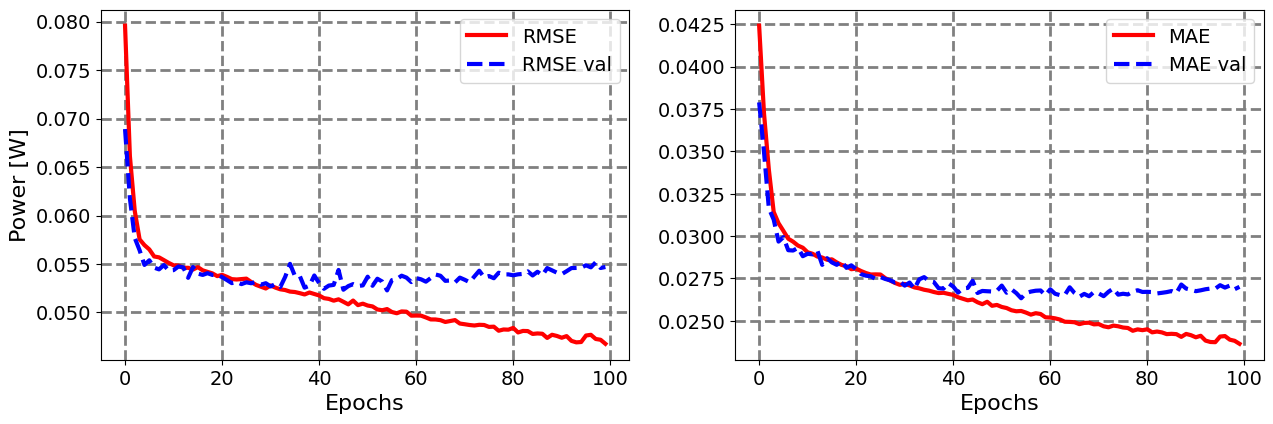

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 14  # Tamaño de fuente general
plt.rcParams['axes.titlesize'] = 18  # Tamaño del título
plt.rcParams['axes.labelsize'] = 16  # Tamaño de las etiquetas de los ejes
plt.rcParams['xtick.labelsize'] = 14  # Tamaño de los números del eje x
plt.rcParams['ytick.labelsize'] = 14  # Tamaño de los números del eje y
plt.rcParams['legend.fontsize'] = 14  # Tamaño de la fuente de la leyenda

# Definir los límites del eje y
y_min_loss, y_max_loss = 0, 0.01  # Cambia estos valores según tus necesidades
y_min_mae, y_max_mae = 0, 0.1  # Cambia estos valores según tus necesidades

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['root_mean_squared_error'], label='RMSE', linewidth=3, color="red", linestyle='-')
plt.plot(history.history['val_root_mean_squared_error'], label='RMSE val', linewidth=3, color="blue", linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Power [W]')
# plt.ylim(y_min_loss, y_max_loss)  # Establecer los límites del eje y para la pérdida
plt.grid(True, which='both', linestyle='--', linewidth=2, color='gray')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='MAE', linewidth=3, color="red", linestyle='-')
plt.plot(history.history['val_mean_absolute_error'], label='MAE val', linewidth=3, color="blue", linestyle='--')
plt.xlabel('Epochs')
# plt.ylabel('Sli [W]')
# plt.ylim(y_min_mae, y_max_mae)  # Establecer los límites del eje y para el MAE
plt.grid(True, which='both', linestyle='--', linewidth=2, color='gray')
plt.legend()

plt.show()


In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_results = model.evaluate(X_test, Y_sli_opti_per_prom_test)

16/16 [==============================] - 1s 3ms/step - loss: 0.0028 - root_mean_squared_error: 0.0525 - mean_absolute_error: 0.0264


1/1 [==============================] - 1s 625ms/step
Tiempo transcurrido: 0.6726078987121582 segundos


<Figure size 600x300 with 0 Axes>

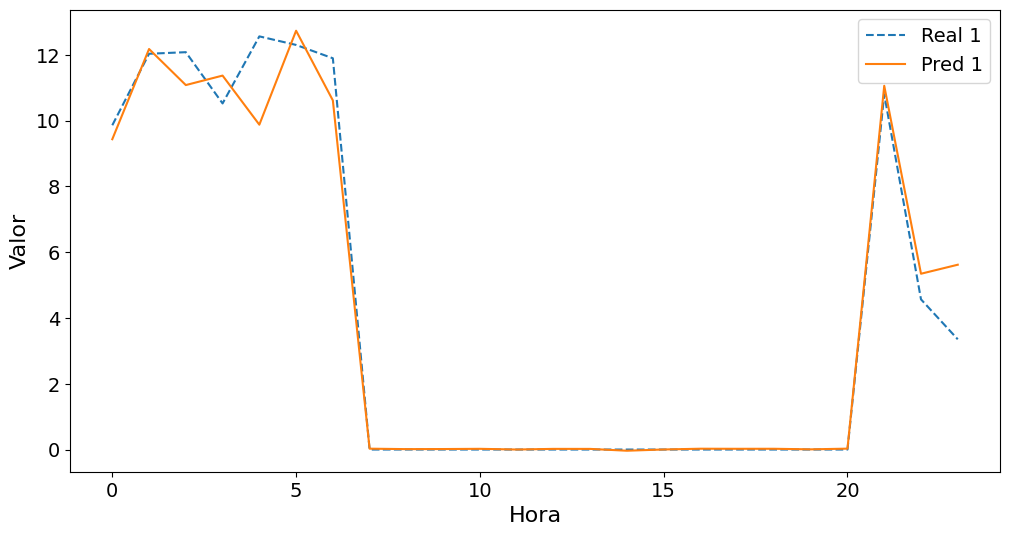

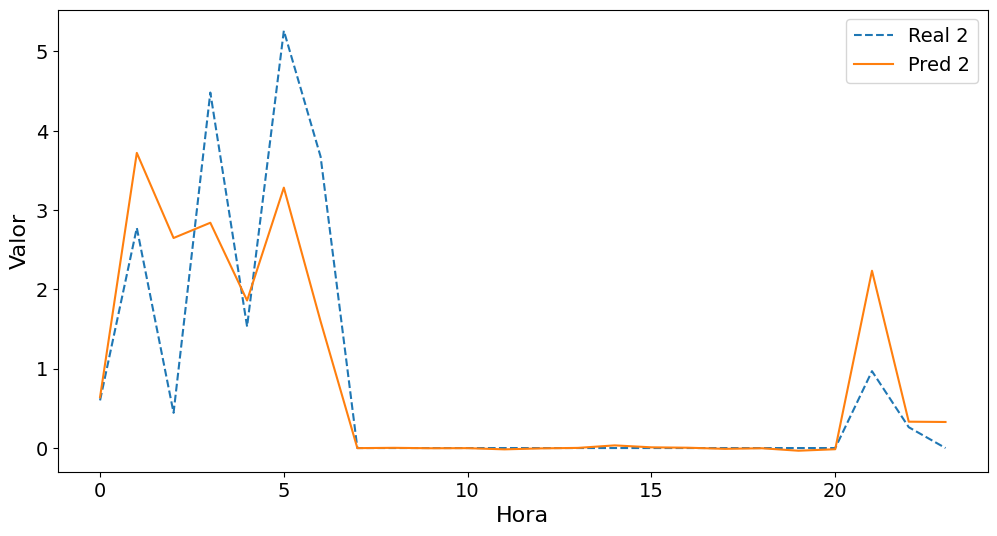

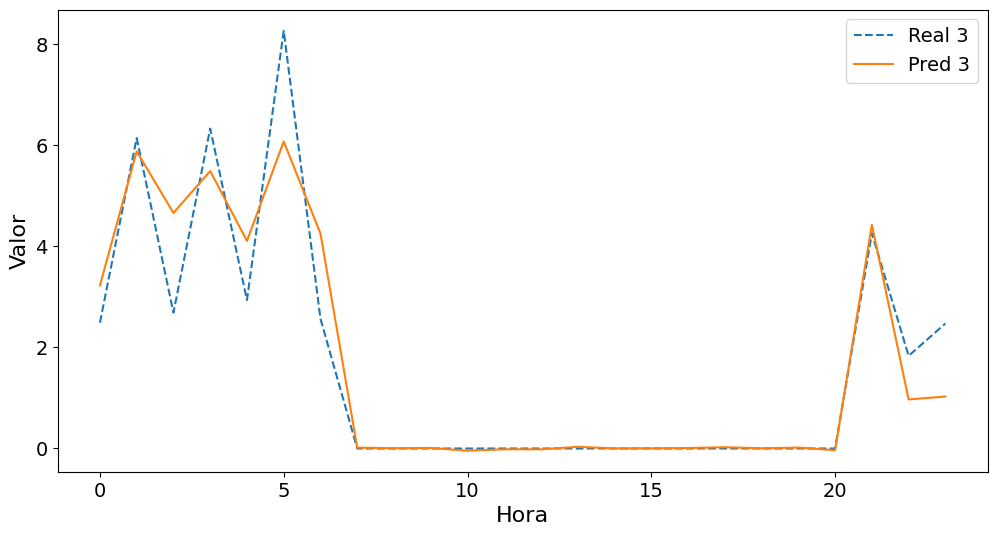

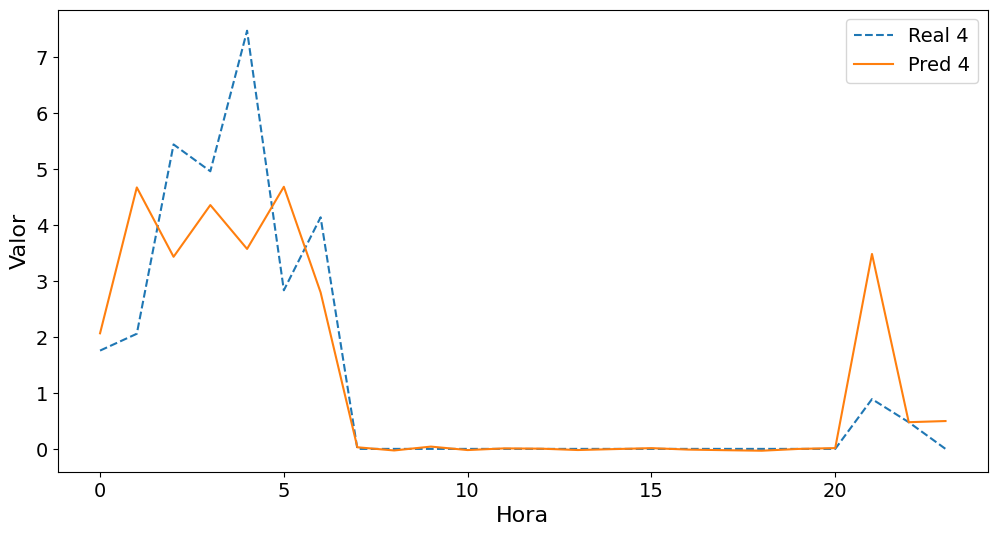

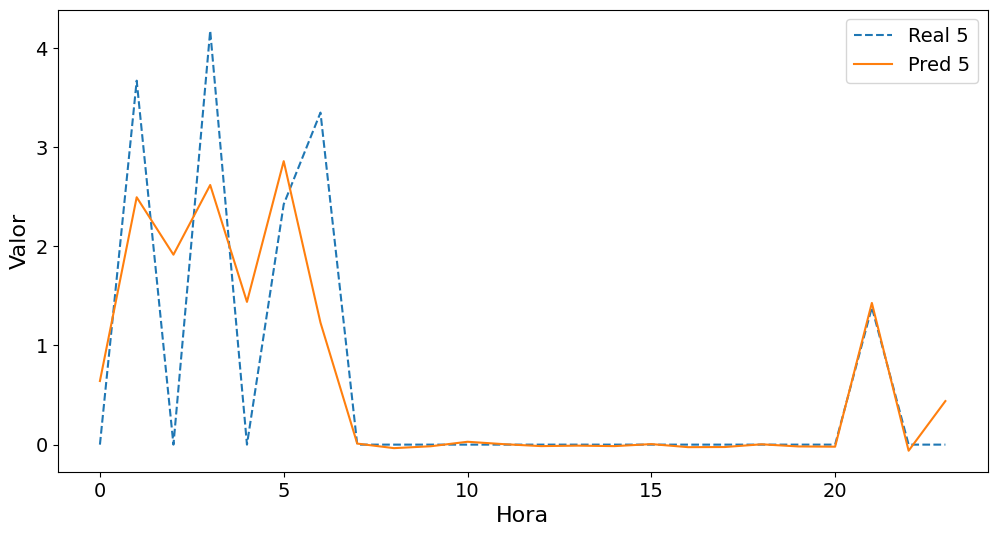

In [ ]:
# Seleccionar un subconjunto específico del conjunto de prueba
example_index = random.randint(1, 200)  # Puedes cambiar este índice para ver diferentes ejemplos
X_example = X_test[example_index:example_index+1]  # Seleccionar un ejemplo específico

# Obtener las predicciones para el subconjunto seleccionado

# Punto de inicio (tic)
start_time = time.time()

# Obtener las predicciones para el subconjunto seleccionado
Y_pred_sli_opti_per_prom = model.predict(X_example)

# Punto de finalización (toc)
end_time = time.time()

# Y_pred_Pms_Pmb_opt = Y_pred_Pms_Pmb_opt * Y1_max
Y_pred_sli_opti_per_prom = Y_pred_sli_opti_per_prom * Y1_max

# Tiempo transcurrido
elapsed_time = end_time - start_time
print(f"Tiempo transcurrido: {elapsed_time} segundos")

# Obtener los valores reales correspondientes para el mismo ejemplo
# Y_true_Pms_Pmb_opt = Y_Pms_Pmb_opt_test[example_index] * Y1_max
Y_true_sli_opti_per_prom = Y_sli_opti_per_prom_test[example_index] * Y1_max

# Gráfica para la primera salida (Pms_Pmb_opt)
plt.figure(figsize=(6, 3))

x= range(1,25)

# # Graficar valores reales y predichos para la primera salida
# for i in range(Y_true_Pms_Pmb_opt.shape[0]):
#     # plt.plot(Y_true_Pms_Pmb_opt[i], label=f'Real Pms_Pmb_opt {i+1}', linestyle='--')
#     # plt.plot(Y_pred_Pms_Pmb_opt[0, i], label=f'Pred Pms_Pmb_opt {i+1}')

#     plt.step(x, Y_true_Pms_Pmb_opt[i], label=f'Real {i+1}', linestyle='--')
#     plt.step(x, Y_pred_Pms_Pmb_opt[0, i], label=f'Pred {i+1}')

# plt.xlabel('Hora')
# plt.ylabel('Valor')
# plt.title('Comparación de Valores Reales y Predichos para Pms_Pmb_opt')
# plt.legend()
# plt.show()

# # Gráfica para la segunda salida (sli_opti_per_prom)
# plt.figure(figsize=(12, 6))

# # Graficar valores reales y predichos para la segunda salida
# for i in range(Y_true_sli_opti_per_prom.shape[0]):
#     plt.plot(Y_true_sli_opti_per_prom[i], label=f'Real {i+1}', linestyle='--')
#     plt.plot(Y_pred_sli_opti_per_prom[0, i], label=f'Pred {i+1}')

# plt.xlabel('Hora')
# plt.ylabel('Valor')
# # plt.title('Comparación de Valores Reales y Predichos para sli_opti_per_prom')
# plt.legend()
# plt.show()

# import matplotlib.pyplot as plt

# Número de filas de los datos
num_filas = Y_true_sli_opti_per_prom.shape[0]

# Crear un gráfico separado para cada fila de datos
for i in range(num_filas):
    plt.figure(figsize=(12, 6))

    # Graficar valores reales y predichos para la fila actual
    plt.plot(Y_true_sli_opti_per_prom[i], label=f'Real {i+1}', linestyle='--')
    plt.plot(Y_pred_sli_opti_per_prom[0, i], label=f'Pred {i+1}')

    plt.xlabel('Hora')
    plt.ylabel('Valor')
    # plt.title(f'Comparación de Valores Reales y Predichos para sli_opti_per_prom (Serie {i+1})')
    plt.legend()
    plt.show()


1/1 [==============================] - 0s 18ms/step
Tiempo transcurrido: 0.06168103218078613 segundos


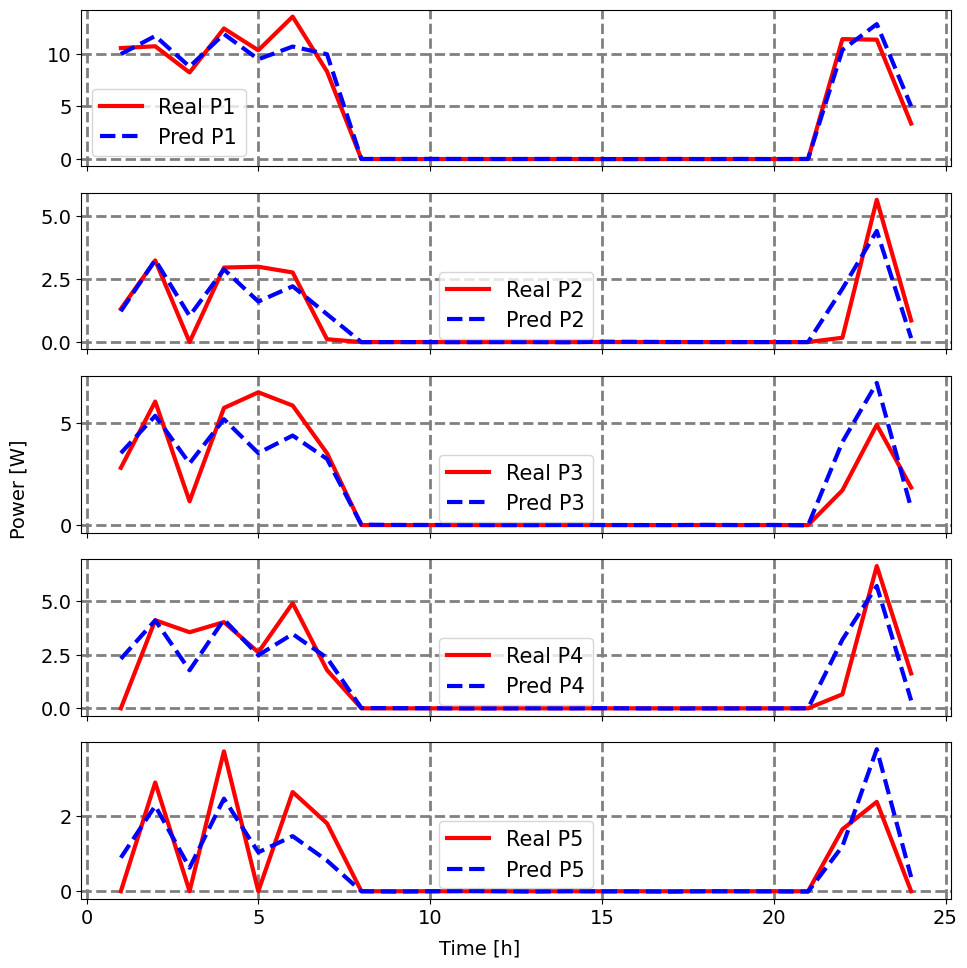

In [ ]:
import matplotlib.pyplot as plt
import random
import time

# Seleccionar un subconjunto específico del conjunto de prueba
example_index = random.randint(1, 200)  # Puedes cambiar este índice para ver diferentes ejemplos
X_example = X_test[example_index:example_index+1]  # Seleccionar un ejemplo específico

# Punto de inicio (tic)
start_time = time.time()

# Obtener las predicciones para el subconjunto seleccionado
Y_pred_sli_opti_per_prom = model.predict(X_example)

# Punto de finalización (toc)
end_time = time.time()

# Y_pred_Pms_Pmb_opt = Y_pred_Pms_Pmb_opt * Y1_max
Y_pred_sli_opti_per_prom = Y_pred_sli_opti_per_prom * Y1_max

# Tiempo transcurrido
elapsed_time = end_time - start_time
print(f"Tiempo transcurrido: {elapsed_time} segundos")

# Obtener los valores reales correspondientes para el mismo ejemplo
# Y_true_Pms_Pmb_opt = Y_Pms_Pmb_opt_test[example_index] * Y1_max
Y_true_sli_opti_per_prom = Y_sli_opti_per_prom_test[example_index] * Y1_max

# Crear subplots
num_filas = Y_true_sli_opti_per_prom.shape[0]
fig, axes = plt.subplots(num_filas, 1, figsize=(10, 10), sharex=True)

x = range(1, 25)

# plt.rcParams['font.size'] = 20  # Tamaño de fuente general
# plt.rcParams['axes.titlesize'] = 18  # Tamaño del título
plt.rcParams['axes.labelsize'] = 20  # Tamaño de las etiquetas de los ejes
plt.rcParams['xtick.labelsize'] = 15  # Tamaño de los números del eje x
plt.rcParams['ytick.labelsize'] = 15  # Tamaño de los números del eje y
plt.rcParams['legend.fontsize'] = 15  # Tamaño de la fuente de la leyenda

# Graficar valores reales y predichos para cada serie
for i in range(num_filas):
    axes[i].plot(x, Y_true_sli_opti_per_prom[i], label=f'Real P{i+1}', linewidth=3, color="red", linestyle='-')
    axes[i].plot(x, Y_pred_sli_opti_per_prom[0, i], label=f'Pred P{i+1}', linewidth=3, color="blue", linestyle='--')
    axes[i].legend()
    axes[i].grid(True, which='both', linestyle='--', linewidth=2, color='gray')

# Añadir un solo nombre de eje x y y para todos los subplots
fig.text(0.5, 0.04, 'Time [h]', ha='center', va='center')
fig.text(0.04, 0.5, 'Power [W]', ha='center', va='center', rotation='vertical')

plt.tight_layout(rect=[0.04, 0.04, 1, 1])
plt.show()


In [ ]:
# def generate_firewall_commands(ip_list, comment="comentario"):
#     commands = "config firewall address\n\n"

#     for ip in ip_list:
#         commands += f"edit\t{ip}\n"
#         commands += f"set comment\t{comment}\n"
#         commands += f"set subnet\t{ip}\n"
#         commands += "next\n\n"

#     commands += "end\n"

#     return commands

# # Ejemplo de uso
# ip_list = [
#     "192.168.1.0/24",
#     "192.168.2.0/24",
#     "192.168.3.0/24"
# ]

# resulting_commands = generate_firewall_commands(ip_list)
# print(resulting_commands)


In [ ]:
# def generate_firewall_commands(ip_list, comment="comentario"):
#     commands = "config firewall address\n\n"

#     for ip in ip_list:
#         commands += f"edit\t{ip}\n"
#         commands += f"set comment\t{comment}\n"
#         commands += f"set subnet\t{ip}\n"
#         commands += "next\n\n"

#     commands += "end\n"

#     return commands

# # Ejemplo de uso
# ip_list = [
#     "192.168.1.0/24",
#     "192.168.2.0/24",
#     "192.168.3.0/24"
# ]

# resulting_commands = generate_firewall_commands(ip_list)
# print(resulting_commands)


In [ ]:
# def generate_firewall_commands(ip_list, group_name="Group_name-1"):
#     address_commands = "config firewall address\n\n"

#     for ip in ip_list:
#         address_commands += f'edit\t"{ip}"\n'
#         address_commands += f'set subnet\t"{ip}"\n'
#         address_commands += "next\n\n"

#     address_commands += "end\n\n"

#     group_command = "config firewall addrgrp\n"
#     group_command += f'edit "{group_name}"\n'
#     group_command += 'set member ' + " ".join([f'"{ip}"' for ip in ip_list]) + "\n"
#     group_command += "next\n"
#     group_command += "end\n"

#     return address_commands + group_command

# # Ejemplo de uso
# ip_list = [
#     "192.168.1.0/24",
#     "192.168.2.0/24",
#     "192.168.3.0/24"
# ]

# resulting_commands = generate_firewall_commands(ip_list)
# print(resulting_commands)
